In [1]:
import numpy as np

In [2]:
""" Example of graph classification problem """
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ModuleList, ReLU, Sequential
import torch.nn.functional as F
import os.path as osp
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')


import random
from datetime import datetime

import numpy as np
import torch
from psd_gnn.dataset import Merge_PSD_Dataset, PSD_Dataset

# from psd_gnn.models.graph_classifier import GNN
from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader, ImbalancedSampler, NeighborLoader
from torch.distributions import Gumbel as G
from torch.optim.lr_scheduler import ReduceLROnPlateau
torch.manual_seed(0)
class GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 n_conv_blocks: int = 1 ) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()

        # add the ability to add one or more conv layers
        conv_blocks = []

        # ability to  add one or more conv blocks
        for _ in range(n_conv_blocks):
            conv_blocks += [
                GCNConv(n_node_features, n_hidden),
                ReLU(),
                GCNConv(n_hidden, n_hidden),
                ReLU(),
            ]

        # group all the conv layers
        self.conv_layers = ModuleList(conv_blocks)


        ## Summary statistics
        self.summary_statistics = Sequential(
            Linear(n_hidden, n_hidden),
            ReLU(),
            Linear(n_hidden, 1))

        self.dist = G(torch.tensor([0.8]), torch.tensor([0.5]))
        self.loss = torch.nn.BCEWithLogitsLoss()


    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor,
                batch: torch.Tensor) -> torch.Tensor:
        """ Processing the GNN model.

        Args:
            x (torch.Tensor): Input features at node level.
            edge_index (torch.Tensor): Index pairs of vertices

        Returns:
            torch.Tensor: output tensor.
        """
        for layer in self.conv_layers:
            if isinstance(layer, GCNConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        x = gap(x, batch)
        out   = self.summary_statistics(x)
        return out
    
    
    def loss_func(self, out, y):
        loss_cross_entropy = self.loss(out, y.float())
        sample = (self.dist.log_prob(self.dist.sample_n(32).squeeze(1)).exp() )
        out=torch.sigmoid(out)
        loss_extreme = torch.mean(out-sample- torch.mul(out,\
                       torch.log( out/(sample+1e-10) ) ) )
        return (loss_cross_entropy+loss_extreme)


def train(model, loader):
    """ Train function

    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        float: Training accuracy.
    """
    model.train()
    total_loss = 0
    out_ret = []
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = model.loss_func(out.float(), data.y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        out_ret+= torch.sigmoid(out).squeeze(1).detach().numpy().tolist()
    return total_loss / len(loader.dataset), out_ret
           
    
import sklearn
@torch.no_grad()
def test(model, loader):
    """ Evaluation function.

    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        tuple (float, list): Testing accuracy, predicted labels.
    """
    model.eval()
    total_correct = 0
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(DEVICE)
        pred = torch.sigmoid(model(data.x, data.edge_index, data.batch))
        pred = (pred >= torch.tensor([0.5])).to(torch.int32)
        y_pred += pred.detach().cpu().numpy().tolist()
        y_true += data.y.detach().cpu().numpy().tolist()
    accuracy = sklearn.metrics.accuracy_score(y_pred, y_true)
    return accuracy, y_pred

In [3]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")
dataset = Merge_PSD_Dataset(node_level=False, binary_labels=True).shuffle()

n_graphs = len(dataset)
train_idx, test_idx = train_test_split( np.arange(n_graphs), train_size=0.6,\
                                       random_state=0, shuffle=True)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=0, shuffle=True)

# REVIEW: imbalanced sampler
# train_sampler = ImbalancedSampler(dataset[train_idx])
# val_sampler = ImbalancedSampler(val_idx)
# test_sampler = ImbalancedSampler(test_idx)
# train_loader = DataLoader(dataset[train_idx], batch_size=args['batch_size'], sampler=train_sampler)
# val_loader = DataLoader(dataset[val_idx], batch_size=args['batch_size'])
# test_loader = DataLoader(dataset[test_idx], batch_size=args['batch_size'])

train_loader = DataLoader(dataset[train_idx], batch_size=32)
val_loader = DataLoader(dataset[val_idx], batch_size=32)
test_loader = DataLoader(dataset[test_idx], batch_size=32)

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = dataset.num_classes

all:   0%| | 0/500 [00:00<?, ?it/s, train_loss=0.321, train_acc=0.792, val_acc=0

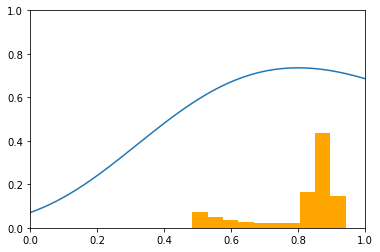

all:  20%|▏| 100/500 [00:55<03:35,  1.86it/s, train_loss=0.11, train_acc=0.823, 

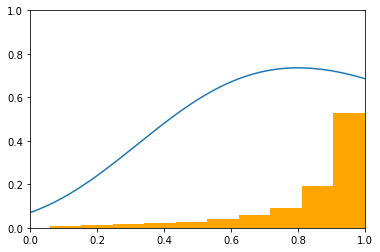

all:  40%|▍| 200/500 [01:48<02:42,  1.84it/s, train_loss=0.0825, train_acc=0.83,

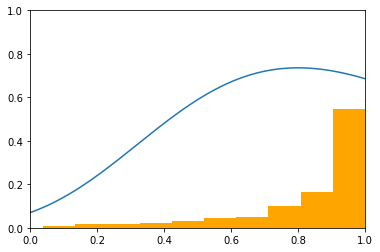

all:  60%|▌| 300/500 [02:42<01:45,  1.89it/s, train_loss=0.0639, train_acc=0.83,

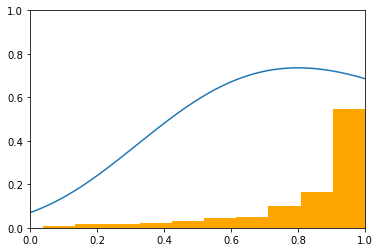

all:  80%|▊| 400/500 [03:34<00:52,  1.90it/s, train_loss=0.0644, train_acc=0.83,

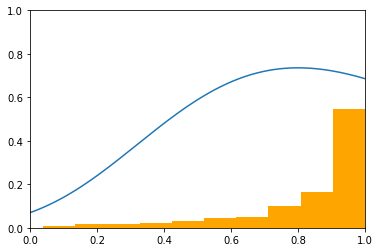

all: 100%|█| 500/500 [04:28<00:00,  1.86it/s, train_loss=0.0609, train_acc=0.83,


In [4]:
''' Build GNN model '''
model = GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(500), desc=f"all")
best = 0
for e in pbar:
    model.train()
    optimizer.zero_grad()
    train_loss, outputs = train(model, train_loader)
    train_acc, y_pred = test(model, train_loader)
    val_acc, _ = test(model, val_loader)
    pbar.set_postfix({"train_loss": train_loss,
                      "train_acc": train_acc,
                      "val_acc": val_acc})
    scheduler.step(train_loss)
    
    if e%100==0:
        actual_Data = model.dist.sample_n( 10000 )
        probs = model.dist.log_prob(actual_Data).exp().squeeze(1).detach().numpy()
    
    
        args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        probs = probs[args]
        actual_Data = actual_Data[args]
        plt.plot(actual_Data, probs)
        x, bins, p = plt.hist(outputs, color='orange', density=True)
        
        for item in p:
            item.set_height(item.get_height()/sum(x))
    
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.show()

In [5]:
## The final training metrics
ys = []
train_acc, y_pred = test(model, train_loader)
for data in train_loader:
    # ys.append(data.y.item())
    ys += data.y.detach().cpu().numpy().tolist()
y_true = ys
print(confusion_matrix(y_true, y_pred))

test_acc, y_pred = test(model, test_loader)

y_true = []
for data in test_loader:
    y_true += data.y.detach().cpu().numpy().tolist()

print(np.unique(y_pred, return_counts=True), \
     "real", np.unique(y_true, return_counts=True) )

conf_mat = confusion_matrix(y_true, y_pred)
prec_val = precision_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)


print("graph level clf:",
      f"workflow all",
      f"binary True",
      f"test acc {test_acc:.4f}",
      f"f1 {f1_val:.4f}",
      f"recall {recall_val:.4f}",
      f"prec {prec_val:.4f}",
      )
print(conf_mat)

[[ 227  542]
 [  85 2835]]
(array([0, 1]), array([ 103, 1127])) real (array([0, 1]), array([251, 979]))
graph level clf: workflow all binary True test acc 0.8276 f1 0.8993 recall 0.9673 prec 0.8403
[[ 71 180]
 [ 32 947]]
